In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(.5),
            # nn.BatchNorm1d(32),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001, weight_decay=0.0001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1975.08it/s]


Epoch   1/100: RMSE_train: 1,732,391, RMSE_val: 1,733,700


100%|██████████| 646/646 [00:00<00:00, 1904.55it/s]


Epoch   2/100: RMSE_train: 1,703,522, RMSE_val: 1,666,044


100%|██████████| 646/646 [00:00<00:00, 2190.62it/s]


Epoch   3/100: RMSE_train: 1,615,489, RMSE_val: 1,558,338


100%|██████████| 646/646 [00:00<00:00, 2233.86it/s]


Epoch   4/100: RMSE_train: 1,476,227, RMSE_val: 1,425,524


100%|██████████| 646/646 [00:00<00:00, 2253.72it/s]


Epoch   5/100: RMSE_train: 1,311,693, RMSE_val: 1,316,407


100%|██████████| 646/646 [00:00<00:00, 2214.82it/s]


Epoch   6/100: RMSE_train: 1,178,853, RMSE_val: 1,278,072


100%|██████████| 646/646 [00:00<00:00, 2247.87it/s]


Epoch   7/100: RMSE_train: 1,099,826, RMSE_val: 1,279,434
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2217.85it/s]


Epoch   8/100: RMSE_train: 1,061,614, RMSE_val: 1,271,138


100%|██████████| 646/646 [00:00<00:00, 2216.62it/s]


Epoch   9/100: RMSE_train: 1,040,383, RMSE_val: 1,266,437


100%|██████████| 646/646 [00:00<00:00, 2217.48it/s]


Epoch  10/100: RMSE_train: 1,023,949, RMSE_val: 1,256,189


100%|██████████| 646/646 [00:00<00:00, 2210.81it/s]


Epoch  11/100: RMSE_train: 1,006,231, RMSE_val: 1,245,814


100%|██████████| 646/646 [00:00<00:00, 2235.59it/s]


Epoch  12/100: RMSE_train: 998,003, RMSE_val: 1,236,197


100%|██████████| 646/646 [00:00<00:00, 2245.17it/s]


Epoch  13/100: RMSE_train: 986,627, RMSE_val: 1,218,857


100%|██████████| 646/646 [00:00<00:00, 2217.07it/s]


Epoch  14/100: RMSE_train: 983,396, RMSE_val: 1,206,014


100%|██████████| 646/646 [00:00<00:00, 2228.73it/s]


Epoch  15/100: RMSE_train: 975,253, RMSE_val: 1,195,768


100%|██████████| 646/646 [00:00<00:00, 2263.69it/s]


Epoch  16/100: RMSE_train: 968,309, RMSE_val: 1,179,489


100%|██████████| 646/646 [00:00<00:00, 2234.40it/s]


Epoch  17/100: RMSE_train: 963,468, RMSE_val: 1,168,858


100%|██████████| 646/646 [00:00<00:00, 2240.09it/s]


Epoch  18/100: RMSE_train: 960,672, RMSE_val: 1,151,841


100%|██████████| 646/646 [00:00<00:00, 2241.92it/s]


Epoch  19/100: RMSE_train: 956,130, RMSE_val: 1,138,740


100%|██████████| 646/646 [00:00<00:00, 2217.81it/s]


Epoch  20/100: RMSE_train: 944,858, RMSE_val: 1,126,203


100%|██████████| 646/646 [00:00<00:00, 2271.55it/s]


Epoch  21/100: RMSE_train: 943,653, RMSE_val: 1,114,851


100%|██████████| 646/646 [00:00<00:00, 2227.01it/s]


Epoch  22/100: RMSE_train: 937,916, RMSE_val: 1,106,568


100%|██████████| 646/646 [00:00<00:00, 2123.67it/s]


Epoch  23/100: RMSE_train: 937,528, RMSE_val: 1,094,239


100%|██████████| 646/646 [00:00<00:00, 2150.21it/s]


Epoch  24/100: RMSE_train: 934,987, RMSE_val: 1,081,818


100%|██████████| 646/646 [00:00<00:00, 2138.33it/s]


Epoch  25/100: RMSE_train: 934,199, RMSE_val: 1,069,955


100%|██████████| 646/646 [00:00<00:00, 2010.46it/s]


Epoch  26/100: RMSE_train: 926,708, RMSE_val: 1,060,640


100%|██████████| 646/646 [00:00<00:00, 1943.27it/s]


Epoch  27/100: RMSE_train: 929,363, RMSE_val: 1,049,164


100%|██████████| 646/646 [00:00<00:00, 2000.72it/s]


Epoch  28/100: RMSE_train: 928,810, RMSE_val: 1,038,054


100%|██████████| 646/646 [00:00<00:00, 2111.25it/s]


Epoch  29/100: RMSE_train: 921,904, RMSE_val: 1,029,767


100%|██████████| 646/646 [00:00<00:00, 2094.91it/s]


Epoch  30/100: RMSE_train: 925,409, RMSE_val: 1,021,707


100%|██████████| 646/646 [00:00<00:00, 2071.04it/s]


Epoch  31/100: RMSE_train: 910,808, RMSE_val: 1,016,365


100%|██████████| 646/646 [00:00<00:00, 2075.07it/s]


Epoch  32/100: RMSE_train: 916,921, RMSE_val: 1,004,937


100%|██████████| 646/646 [00:00<00:00, 2141.19it/s]


Epoch  33/100: RMSE_train: 911,607, RMSE_val: 998,364


100%|██████████| 646/646 [00:00<00:00, 2089.39it/s]


Epoch  34/100: RMSE_train: 918,131, RMSE_val: 996,756


100%|██████████| 646/646 [00:00<00:00, 2064.48it/s]


Epoch  35/100: RMSE_train: 909,214, RMSE_val: 984,718


100%|██████████| 646/646 [00:00<00:00, 2193.75it/s]


Epoch  36/100: RMSE_train: 913,527, RMSE_val: 977,287


100%|██████████| 646/646 [00:00<00:00, 2118.69it/s]


Epoch  37/100: RMSE_train: 906,470, RMSE_val: 971,949


100%|██████████| 646/646 [00:00<00:00, 2174.64it/s]


Epoch  38/100: RMSE_train: 902,725, RMSE_val: 963,423


100%|██████████| 646/646 [00:00<00:00, 2238.42it/s]


Epoch  39/100: RMSE_train: 904,621, RMSE_val: 958,559


100%|██████████| 646/646 [00:00<00:00, 2241.48it/s]


Epoch  40/100: RMSE_train: 902,903, RMSE_val: 955,546


100%|██████████| 646/646 [00:00<00:00, 2216.06it/s]


Epoch  41/100: RMSE_train: 901,363, RMSE_val: 952,388


100%|██████████| 646/646 [00:00<00:00, 2290.91it/s]


Epoch  42/100: RMSE_train: 900,252, RMSE_val: 948,458


100%|██████████| 646/646 [00:00<00:00, 2270.56it/s]


Epoch  43/100: RMSE_train: 903,622, RMSE_val: 940,915


100%|██████████| 646/646 [00:00<00:00, 2278.92it/s]


Epoch  44/100: RMSE_train: 901,230, RMSE_val: 937,793


100%|██████████| 646/646 [00:00<00:00, 2153.68it/s]


Epoch  45/100: RMSE_train: 894,342, RMSE_val: 931,890


100%|██████████| 646/646 [00:00<00:00, 2255.31it/s]


Epoch  46/100: RMSE_train: 891,790, RMSE_val: 930,339


100%|██████████| 646/646 [00:00<00:00, 2261.30it/s]


Epoch  47/100: RMSE_train: 893,786, RMSE_val: 923,429


100%|██████████| 646/646 [00:00<00:00, 2287.75it/s]


Epoch  48/100: RMSE_train: 893,525, RMSE_val: 931,001
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2308.68it/s]


Epoch  49/100: RMSE_train: 891,162, RMSE_val: 918,686


100%|██████████| 646/646 [00:00<00:00, 2270.14it/s]


Epoch  50/100: RMSE_train: 895,176, RMSE_val: 915,176


100%|██████████| 646/646 [00:00<00:00, 2270.19it/s]


Epoch  51/100: RMSE_train: 889,886, RMSE_val: 912,346


100%|██████████| 646/646 [00:00<00:00, 2270.63it/s]


Epoch  52/100: RMSE_train: 890,816, RMSE_val: 910,476


100%|██████████| 646/646 [00:00<00:00, 2309.45it/s]


Epoch  53/100: RMSE_train: 890,422, RMSE_val: 924,311
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2276.70it/s]


Epoch  54/100: RMSE_train: 891,279, RMSE_val: 907,504


100%|██████████| 646/646 [00:00<00:00, 2291.43it/s]


Epoch  55/100: RMSE_train: 893,576, RMSE_val: 912,799
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2314.10it/s]


Epoch  56/100: RMSE_train: 883,330, RMSE_val: 906,809


100%|██████████| 646/646 [00:00<00:00, 2251.02it/s]


Epoch  57/100: RMSE_train: 889,875, RMSE_val: 905,877


100%|██████████| 646/646 [00:00<00:00, 2287.62it/s]


Epoch  58/100: RMSE_train: 884,532, RMSE_val: 908,677
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2305.55it/s]


Epoch  59/100: RMSE_train: 882,687, RMSE_val: 904,901


100%|██████████| 646/646 [00:00<00:00, 2299.23it/s]


Epoch  60/100: RMSE_train: 886,182, RMSE_val: 902,986


100%|██████████| 646/646 [00:00<00:00, 2257.54it/s]


Epoch  61/100: RMSE_train: 878,990, RMSE_val: 904,098
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2329.48it/s]


Epoch  62/100: RMSE_train: 877,819, RMSE_val: 902,239


100%|██████████| 646/646 [00:00<00:00, 2295.45it/s]


Epoch  63/100: RMSE_train: 878,467, RMSE_val: 901,390


100%|██████████| 646/646 [00:00<00:00, 2272.91it/s]


Epoch  64/100: RMSE_train: 881,042, RMSE_val: 910,140
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2291.64it/s]


Epoch  65/100: RMSE_train: 882,144, RMSE_val: 912,733
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 2244.17it/s]


Epoch  66/100: RMSE_train: 870,391, RMSE_val: 899,307


100%|██████████| 646/646 [00:00<00:00, 2310.83it/s]


Epoch  67/100: RMSE_train: 876,413, RMSE_val: 902,246
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2291.32it/s]


Epoch  68/100: RMSE_train: 881,234, RMSE_val: 898,188


100%|██████████| 646/646 [00:00<00:00, 2257.47it/s]


Epoch  69/100: RMSE_train: 878,997, RMSE_val: 898,268
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 2272.35it/s]


Epoch  70/100: RMSE_train: 871,065, RMSE_val: 898,946
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 2287.67it/s]


Epoch  71/100: RMSE_train: 881,042, RMSE_val: 903,395
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 2269.95it/s]


Epoch  72/100: RMSE_train: 869,032, RMSE_val: 898,248
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 2262.97it/s]


Epoch  73/100: RMSE_train: 875,662, RMSE_val: 907,763
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 2130.33it/s]


Epoch  74/100: RMSE_train: 881,003, RMSE_val: 899,904
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 2292.53it/s]


Epoch  75/100: RMSE_train: 868,266, RMSE_val: 898,967
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 2305.64it/s]


Epoch  76/100: RMSE_train: 874,048, RMSE_val: 900,685
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 2299.99it/s]


Epoch  77/100: RMSE_train: 867,778, RMSE_val: 899,667
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 2259.09it/s]


Epoch  78/100: RMSE_train: 874,935, RMSE_val: 901,498
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 2337.65it/s]


Epoch  79/100: RMSE_train: 864,857, RMSE_val: 901,872
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 2237.14it/s]


Epoch  80/100: RMSE_train: 868,820, RMSE_val: 910,541
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 2257.44it/s]


Epoch  81/100: RMSE_train: 863,926, RMSE_val: 908,046
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 2268.54it/s]


Epoch  82/100: RMSE_train: 867,686, RMSE_val: 904,345
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 2163.94it/s]


Epoch  83/100: RMSE_train: 869,981, RMSE_val: 899,812
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 2097.77it/s]


Epoch  84/100: RMSE_train: 873,381, RMSE_val: 901,301
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 2024.62it/s]


Epoch  85/100: RMSE_train: 879,496, RMSE_val: 901,264
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 2019.39it/s]


Epoch  86/100: RMSE_train: 860,166, RMSE_val: 901,230
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 2089.57it/s]


Epoch  87/100: RMSE_train: 858,459, RMSE_val: 904,631
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 2074.94it/s]


Epoch  88/100: RMSE_train: 870,111, RMSE_val: 901,889
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 2079.25it/s]


Epoch  89/100: RMSE_train: 868,405, RMSE_val: 904,758
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 2158.04it/s]


Epoch  90/100: RMSE_train: 873,492, RMSE_val: 902,003
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 2259.90it/s]


Epoch  91/100: RMSE_train: 853,405, RMSE_val: 901,768
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 2226.59it/s]


Epoch  92/100: RMSE_train: 859,661, RMSE_val: 903,841
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 2195.57it/s]


Epoch  93/100: RMSE_train: 864,104, RMSE_val: 914,413
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 2252.78it/s]


Epoch  94/100: RMSE_train: 867,455, RMSE_val: 903,554
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 2312.61it/s]


Epoch  95/100: RMSE_train: 852,298, RMSE_val: 903,275
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 2305.76it/s]


Epoch  96/100: RMSE_train: 862,497, RMSE_val: 905,642
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 2256.34it/s]


Epoch  97/100: RMSE_train: 863,198, RMSE_val: 904,053
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 2250.56it/s]


Epoch  98/100: RMSE_train: 859,824, RMSE_val: 905,762
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 2281.52it/s]


Epoch  99/100: RMSE_train: 860,707, RMSE_val: 905,934
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 2154.16it/s]


Epoch 100/100: RMSE_train: 857,807, RMSE_val: 905,089
EarlyStopping counter: 32 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   785979.491  452757.734  0.583  0.604
val     901667.186  508699.367  0.637  0.469
test    929256.359  515538.613  0.626  0.442
--------------------------------------------
total   828514.130  470907.292  0.597  0.558


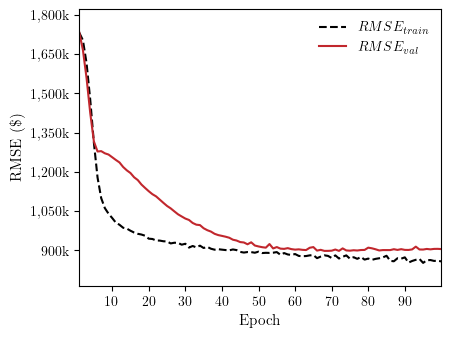

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

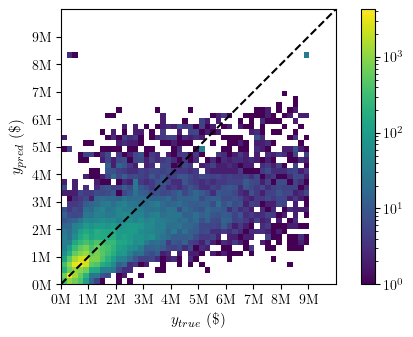

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')